# Homework 2: Language Models and Neural Networks
#### CSCI 3832 Natural Language Processing

## Julia Troni

In this homework we're going to be looking at the bigram language model you've implemented in class, and extend it to trigrams.

Instead of looking at the Bible, we'll re-visit the sentiment analysis problem from the previous homework.

- This dataset contains a split of unlabeled movie reviews.
- We'll train our language model using this unlabeled split (i.e. we'll pretrain our language model) and then we'll use this model as a starting off point for a neural classification model (i.e. finetuning), which we'll use to do sentiment classification.
- Finally, we'll replace our trained embeddings with Glove pretrained vectors, to see if we get any improvement.

## Section 1: Neural Language Modeling

We'll first load the unsupervised data. Set the data dir below to the directory you used for Homework 1, to prevent copying the data twice.

In [1]:
import os, random, sys, matplotlib.pyplot as plt
import torch, torch.nn as nn, numpy
from nltk.tokenize import word_tokenize

In [2]:
data_dir = 'aclImdb/'
data_limit = 15000

def read_folder(folder):
    examples = []
    files = os.listdir(folder)
    files.sort()
    for fname in files[:data_limit]:
        with open(os.path.join(folder, fname), encoding='utf8') as f:
            examples.append(f.readline().strip())
    return examples

unsup_examples = read_folder(os.path.join(data_dir, 'train/unsup/'))
print(unsup_examples[0])

I admit, the great majority of films released before say 1933 are just not for me. Of the dozen or so "major" silents I have viewed, one I loved (The Crowd), and two were very good (The Last Command and City Lights, that latter Chaplin circa 1931).<br /><br />So I was apprehensive about this one, and humor is often difficult to appreciate (uh, enjoy) decades later. I did like the lead actors, but thought little of the film.<br /><br />One intriguing sequence. Early on, the guys are supposed to get "de-loused" and for about three minutes, fully dressed, do some schtick. In the background, perhaps three dozen men pass by, all naked, white and black (WWI ?), and for most, their butts, part or full backside, are shown. Was this an early variation of beefcake courtesy of Howard Hughes?


The dataset also comes with a pre-made vocabulary, which we'll rely on for this section of the homework. We'll eventually convert our words to indices, so lets store the words in a dictionary, mapping each to a unique integer.

In [3]:
vocabulary_file = os.path.join(data_dir, 'imdb.vocab')

raw_vocabulary = []
with open(vocabulary_file, 'r', encoding='utf8') as f:
    for line in f:
        raw_vocabulary.append(line.strip())

#Limit our vocabulary size to top 5k words
raw_vocabulary = raw_vocabulary[:5000]

# Add in our special tokens
special_tokens = ['<s>', '</s>', '<unk>']

vocabulary = {}

'''
Your code here.

Create the vocabulary dictionary by prepending the special tokens to the raw vocabulary, and enumerating them.

10 pts.

'''
for indx in range(len(special_tokens)):
    vocabulary[special_tokens[indx]]=indx
for indx in range(len(raw_vocabulary)):
    vocabulary[raw_vocabulary[indx]]=indx+3


In [4]:
assert isinstance(vocabulary, dict)
assert len(vocabulary) == 5003
assert vocabulary['<s>'] == 0
assert vocabulary['significance'] == 5002


Now that we have a vocabulary, we can process the unsupervised examples we loaded earlier into actual training data our model can read.

First, we'll tokenize the text normally:

In [5]:
"""
This block may take a while (<5 minutes) to run, but you only have to run it once, so make sure you don't modify the tokenized_examples list after it's completed.
While you're writing your code, consider limiting unsup_examples to the first 5 examples as a smoke test before you run the loop over all examples
"""

from nltk.tokenize import word_tokenize

tokenized_examples = []
sos_id = vocabulary['<s>'] #start of sequence
eos_id = vocabulary['</s>'] #end of sequence
unk_id = vocabulary['<unk>']

for example in unsup_examples[0:5]:
    example_tokens = [token.lower() for token in word_tokenize(example)]

    token_ids = [sos_id]
    for token in example_tokens:
        '''
            Your code here.

            The above loop iterates over the tokens in a single example. If a token is in our vocabulary, then add it to token_ids. If not, add the unknown token.

            10 pts.

        '''
        if token in vocabulary.keys():
            token_ids.append(vocabulary.get(token))
        elif token not in vocabulary:
            token_ids.append(unk_id)
            
    token_ids.append(eos_id)
    tokenized_examples.append(token_ids)

In [6]:
assert len(tokenized_examples[0]) == 191
assert tokenized_examples[0] == [0, 11, 940, 2, 3, 86, 2091, 6, 107, 618, 158, 134, 2, 25, 43, 22, 16, 71, 2, 6, 3, 2587, 42, 38, 2, 653, 2, 2, 11, 27, 2361, 2, 29, 11, 440, 2, 3, 2260, 2, 2, 4, 108, 70, 55, 51, 2, 3, 229, 4300, 4, 522, 2648, 2, 13, 1517, 3053, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 38, 11, 14, 2, 44, 12, 29, 2, 4, 468, 8, 388, 854, 7, 1103, 2, 2, 2, 345, 2, 2738, 294, 2, 11, 120, 39, 3, 471, 154, 2, 19, 201, 115, 6, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 29, 1731, 695, 2, 387, 21, 2, 3, 473, 25, 410, 7, 77, 2, 2, 2, 4, 16, 44, 291, 228, 2, 1300, 1796, 2, 84, 50, 2, 2, 10, 3, 943, 2, 367, 291, 2587, 334, 1320, 33, 2, 31, 1267, 2, 444, 4, 323, 2, 2, 49, 2, 2, 4, 16, 90, 2, 66, 2, 2, 173, 42, 377, 2, 2, 25, 598, 2, 14, 12, 34, 387, 2, 6, 2, 2, 6, 1951, 2, 49, 1]

Now we can create our bigram data. We'll make use of the torch Dataset class. We only need to implement the `__getitem__` and `__len__` methods to make this work with other existing torch tools.

For this dataset, for each example, iterate over its bigrams. If either one of the tokens is an unknown token, then do not save the bigram. Since we're using a small vocabulary, we'll have a lot of unknowns, and we don't want our model to always predict this token as the most likely next token.

Note that with a normal sized vocabulary, training set, and model, you wouldn't necessarily want to do this -- unknowns would hopefully be relatively rare.

In [7]:
import torch

class BigramDataset(torch.utils.data.Dataset):

    def __init__(self, tokenized_data):

        self.examples = []
        for example in tokenized_data:              #Iterate over our dataset
            for i in range(0,len(example) - 1):     #Iterate over the tokens of the example
                '''
                    Your code here.

                    Bigrams should be a tuple of integers: (example[i], example[i+1])
                    For each bigram, if either of example[i] or example[i+1] are unknown then do not add the bigram to our examples.

                    10 pts.
                '''
                if (example[i]==unk_id or example[i+1]==unk_id):
                    continue;
                else: 
                    self.examples.append((example[i], example[i+1]))

    def __getitem__(self, idx):

        return self.examples[idx]

    def __len__(self):

        return len(self.examples)




Now we'll define the bigram model. This is similar to the one in class: the input is a single token, and the model outputs a probability over the whole vocabulary.

In [8]:
import torch.nn as nn

class BigramLM(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_hidden_layers):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.hidden_layer_1 = nn.Linear(embedding_dim, hidden_dim)
        self.hidden_layers = nn.ModuleList(
            [nn.Linear(hidden_dim, hidden_dim) for _ in range(num_hidden_layers - 1)]
        )
        self.output_layer = nn.Linear(hidden_dim, vocab_size)

        self.relu = nn.ReLU()

    def forward(self, input):

        embedding = self.embedding(input)

        hidden = self.relu(self.hidden_layer_1(embedding))

        for layer in self.hidden_layers:
            hidden = self.relu(layer(hidden))

        output = self.output_layer(hidden)

        return output

Now we'll train the model. This training loop is similar to the one shown in lecture, with a couple of differences.

In [9]:
# Training Loop

#Initialize our model -- keep it small with 1 hidden layer, and embedding sizes of 50
bigram_model = BigramLM(len(vocabulary), 50, 50, 1)

#Initialize our dataset using a subset of examples
bigram_dataset = BigramDataset(tokenized_examples[:5000])

criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(bigram_model.parameters())            #AdamW is a popularly used optimizer
# optimizer = torch.optim.SGD(bigram_model.parameters(), lr=0.5)    #Either of these optimizers could be used

softmax = nn.Softmax(dim=2)

epochs = 30
batch_size = 32
print_frequency = 1000

avg_loss_list=[] #list to hold losses to plot later

#We'll create an instance of a torch dataloader to collate our data. This class handles batching and shuffling (should be done each epoch)
train_dataloader = torch.utils.data.DataLoader(bigram_dataset, batch_size=batch_size, shuffle=True)

for i in range(epochs):
    print('### Epoch: ' + str(i+1) + ' ###')

    bigram_model.train()
    avg_loss = 0

    for step, data in enumerate(train_dataloader):
        x, y = data
        x = x.unsqueeze(1)


        optimizer.zero_grad()

        model_output = bigram_model(x)
        model_output_probabilities = softmax(model_output)

        loss = criteria(model_output_probabilities.squeeze(1), y)

        loss.backward()
        optimizer.step()

        avg_loss += loss.item()
        if step % print_frequency == 1:
            print('epoch: {} batch: {} loss: {}'.format(
                i,
                step,
                avg_loss / print_frequency
            ))
            avg_loss_list.append(avg_loss) #keep track of average loss
            avg_loss = 0

### Epoch: 1 ###
epoch: 0 batch: 1 loss: 0.01703556442260742
### Epoch: 2 ###
epoch: 1 batch: 1 loss: 0.01703548240661621
### Epoch: 3 ###
epoch: 2 batch: 1 loss: 0.017035235404968263
### Epoch: 4 ###
epoch: 3 batch: 1 loss: 0.017034703254699708
### Epoch: 5 ###
epoch: 4 batch: 1 loss: 0.01703206443786621
### Epoch: 6 ###
epoch: 5 batch: 1 loss: 0.017000323295593263
### Epoch: 7 ###
epoch: 6 batch: 1 loss: 0.016988926887512208
### Epoch: 8 ###
epoch: 7 batch: 1 loss: 0.016927145004272462
### Epoch: 9 ###
epoch: 8 batch: 1 loss: 0.016844003677368165
### Epoch: 10 ###
epoch: 9 batch: 1 loss: 0.016849642753601075
### Epoch: 11 ###
epoch: 10 batch: 1 loss: 0.016908321380615234
### Epoch: 12 ###
epoch: 11 batch: 1 loss: 0.016807310104370116
### Epoch: 13 ###
epoch: 12 batch: 1 loss: 0.016894169807434082
### Epoch: 14 ###
epoch: 13 batch: 1 loss: 0.01676465034484863
### Epoch: 15 ###
epoch: 14 batch: 1 loss: 0.016738129615783692
### Epoch: 16 ###
epoch: 15 batch: 1 loss: 0.016803789138793945

Use the loop above to train the model for at least 1 epoch.

1. Modify the loop to keep track of the average loss before it's reset. Then, plot the losses using matplotlib below.

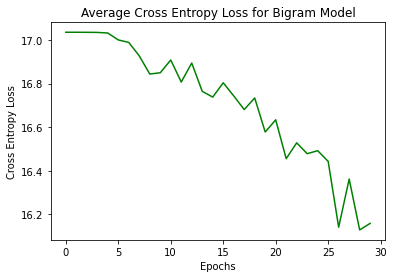

In [10]:
'''
Your code here.

The average loss is reset after print_frequency iterations. Before it's set to 0, store it in a list that will persist throughout training.

10 pts.
'''

fig, ax = plt.subplots(1, 1)
# Index 4 Axes arrays in 4 subplots within 1 Figure: 
ax.plot( avg_loss_list, 'g') #row=0, column=0
ax.set_xlabel('Epochs')
ax.set_ylabel('Cross Entropy Loss')
plt.title("Average Cross Entropy Loss for Bigram Model")
plt.show()



Now we'll modify our model and dataset to create a trigram language model. Here, the input will be two words rather than 1. The output will remain the same.

Hint: since we have two inputs, we'll want to combine them in some way after we get their embeddings. An easy way to do this would be to concatenate the two embeddings together, creating a new vector of size 2*embedding_dim. This will be the input size of the first hidden dimension.

In [11]:
class TrigramDataset(torch.utils.data.Dataset):

    def __init__(self, tokenized_data):

        self.examples = []
        for example in tokenized_data:              #Iterate over our dataset
            for i in range(0,len(example) - 2):     #Iterate over the tokens of the example
                
                #Trigrams should be a tuple of integers: (example[i], example[i+1], example[i+2])
                if (example[i]==unk_id or example[i+1]==unk_id or example[i+2]==unk_id):
                    continue;
                else:
                    self.examples.append((example[i], example[i+1], example[i+2]))


    def __getitem__(self, idx):

        return self.examples[idx]

    def __len__(self):

        return len(self.examples)
        
        

In [12]:
class TrigramLM(nn.Module):
    '''Hint: since we have two inputs, we'll want to combine them in some way after we get their embeddings.
    An easy way to do this would be to concatenate the two embeddings together, 
    creating a new vector of size 2*embedding_dim. 
    This will be the input size of the first hidden dimension.'''

    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_hidden_layers):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)


        #Embedding_dim will have to be modified
        self.hidden_layer_1 = nn.Linear(embedding_dim*2, hidden_dim) 
        
        self.hidden_layers = nn.ModuleList(
            [nn.Linear(hidden_dim, hidden_dim) for _ in range(num_hidden_layers - 1)]
        )
        self.output_layer = nn.Linear(hidden_dim, vocab_size)

        self.relu = nn.ReLU()


    def forward(self, input_1, input_2):
        # Hint: we'll need to get an embedding for our second input somehow
        self.embedding_1 = self.embedding(input_1)
        self.embedding_2 = self.embedding(input_2)

        # Hint: This might be one way to combine our embeddings
        embedding = torch.cat((self.embedding_1,self.embedding_2),2)
        
        
        hidden = self.relu(self.hidden_layer_1(embedding))

        for layer in self.hidden_layers:
            hidden = self.relu(layer(hidden))

        output = self.output_layer(hidden)

        return output

In [13]:
trigram_loss_list=[]
def train_trigram(trigram_model, trigram_dataset):

    criteria = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(trigram_model.parameters())
    # optimizer = torch.optim.SGD(trigram_model.parameters(), lr=0.5)

    softmax = nn.Softmax(dim=2)

    epochs = 30
    batch_size = 32
    print_frequency = 1000



    train_dataloader = torch.utils.data.DataLoader(trigram_dataset, batch_size=batch_size, shuffle=True)

    for i in range(epochs):
        print('### Epoch: ' + str(i+1) + ' ###')

        trigram_model.train()
        avg_loss = 0
    
        for step, data in enumerate(train_dataloader):

            
            x, b,y = data

            x = x.unsqueeze(1)
            b = b.unsqueeze(1)
            

            optimizer.zero_grad()

            model_output = trigram_model(x,b)
            model_output_probabilities = softmax(model_output)

            loss = criteria(model_output_probabilities.squeeze(1), y)

            loss.backward()
            optimizer.step()

            avg_loss += loss.item()
            if step % print_frequency == 1:
                print('epoch: {} batch: {} loss: {}'.format(
                    i,
                    step,
                    avg_loss / print_frequency
                ))
                trigram_loss_list.append(avg_loss) #keep track of average loss
                avg_loss = 0
                

In [14]:
"""
Complete the following code block by initializing the model/dataset and training for at least one epoch
Hint: the models and dataset should be _extremely_ similar to the bigram model and dataset

20 pts.
"""



trigram_model = TrigramLM(len(vocabulary), 50, 50, 1)
#Initialize our dataset using a subset of examples
trigram_dataset = TrigramDataset(tokenized_examples[:5000])


train_trigram(trigram_model, trigram_dataset)

### Epoch: 1 ###
epoch: 0 batch: 1 loss: 0.017035577774047853
### Epoch: 2 ###
epoch: 1 batch: 1 loss: 0.0170355110168457
### Epoch: 3 ###
epoch: 2 batch: 1 loss: 0.01703536033630371
### Epoch: 4 ###
epoch: 3 batch: 1 loss: 0.017035176277160644
### Epoch: 5 ###
epoch: 4 batch: 1 loss: 0.017034628868103027
### Epoch: 6 ###
epoch: 5 batch: 1 loss: 0.01702963161468506
### Epoch: 7 ###
epoch: 6 batch: 1 loss: 0.01702789783477783
### Epoch: 8 ###
epoch: 7 batch: 1 loss: 0.016854925155639647
### Epoch: 9 ###
epoch: 8 batch: 1 loss: 0.016915714263916016
### Epoch: 10 ###
epoch: 9 batch: 1 loss: 0.016915902137756348
### Epoch: 11 ###
epoch: 10 batch: 1 loss: 0.016852542877197264
### Epoch: 12 ###
epoch: 11 batch: 1 loss: 0.01677695369720459
### Epoch: 13 ###
epoch: 12 batch: 1 loss: 0.016858395576477052
### Epoch: 14 ###
epoch: 13 batch: 1 loss: 0.01664865303039551
### Epoch: 15 ###
epoch: 14 batch: 1 loss: 0.016608195304870607
### Epoch: 16 ###
epoch: 15 batch: 1 loss: 0.016598743438720705
##

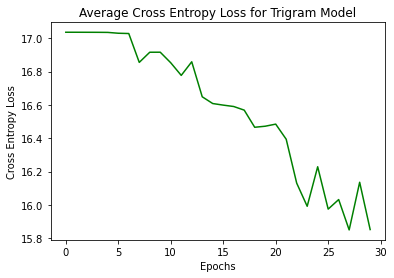

In [15]:

fig, ax = plt.subplots(1, 1)
ax.plot( trigram_loss_list, 'g') #row=0, column=0
ax.set_xlabel('Epochs')
ax.set_ylabel('Cross Entropy Loss')
plt.title("Average Cross Entropy Loss for Trigram Model")
plt.show()



To complete this section, complete the Trigram model and dataset, and train the model for at least 1 epoch.

## Section 2: Sentiment Analysis

In this section we'll compare how a neural model similar to the one above performs on sentiment analysis. Then, we'll replace the embeddings with pretrained ones to see if that increases our performance. To make our life easier, we'll use the glove vocabulary for both models.

You can download the embeddings from here: https://nlp.stanford.edu/projects/glove/

The glove vectors are distributed as a text file, with the word in the first column, and the embeddings in the remaining columns. We'll read in the embeddings here.

In [16]:
glove_file = 'glove.6B.50d.txt'

embeddings_dict = {}

with open(glove_file, 'r', encoding='utf8') as f:
    for i, line in enumerate(f):
        if i == 0:
            print(line)
        line = line.strip().split(' ')
        word = line[0]
        embed = numpy.asarray(line[1:], "float")

        embeddings_dict[word] = embed

print('Loaded {} words from glove'.format(len(embeddings_dict)))

embedding_matrix = numpy.zeros((len(embeddings_dict)+1, 50)) #add 1 for padding

word2id = {}
for i, word in enumerate(embeddings_dict.keys()):

    word2id[word] = i                                #Map each word to an index
    embedding_matrix[i] = embeddings_dict[word]      #That index holds the Glove embedding in the embedding matrix

# Our joint vocabulary for both models / sanity check to see if we've loaded it correctly:
print(word2id['the'])
print(embedding_matrix[word2id['the']])

word2id['<pad>'] = embedding_matrix.shape[0] - 1
print(embedding_matrix[word2id['<pad>']])


the 0.418 0.24968 -0.41242 0.1217 0.34527 -0.044457 -0.49688 -0.17862 -0.00066023 -0.6566 0.27843 -0.14767 -0.55677 0.14658 -0.0095095 0.011658 0.10204 -0.12792 -0.8443 -0.12181 -0.016801 -0.33279 -0.1552 -0.23131 -0.19181 -1.8823 -0.76746 0.099051 -0.42125 -0.19526 4.0071 -0.18594 -0.52287 -0.31681 0.00059213 0.0074449 0.17778 -0.15897 0.012041 -0.054223 -0.29871 -0.15749 -0.34758 -0.045637 -0.44251 0.18785 0.0027849 -0.18411 -0.11514 -0.78581

Loaded 400000 words from glove
0
[ 4.1800e-01  2.4968e-01 -4.1242e-01  1.2170e-01  3.4527e-01 -4.4457e-02
 -4.9688e-01 -1.7862e-01 -6.6023e-04 -6.5660e-01  2.7843e-01 -1.4767e-01
 -5.5677e-01  1.4658e-01 -9.5095e-03  1.1658e-02  1.0204e-01 -1.2792e-01
 -8.4430e-01 -1.2181e-01 -1.6801e-02 -3.3279e-01 -1.5520e-01 -2.3131e-01
 -1.9181e-01 -1.8823e+00 -7.6746e-01  9.9051e-02 -4.2125e-01 -1.9526e-01
  4.0071e+00 -1.8594e-01 -5.2287e-01 -3.1681e-01  5.9213e-04  7.4449e-03
  1.7778e-01 -1.5897e-01  1.2041e-02 -5.4223e-02 -2.9871e-01 -1.5749e-01
 -3.47

We'll create another dataset for our (now labeled) movie reviews. Do not change the max_length values.

In [17]:
# Create a classification dataset for the movie reviews


class MovieReviewDataset(torch.utils.data.Dataset):

    def __init__(self, directory=None, split=None, word2id=None, finalized_data=None, data_limit=250, max_length=256):
        """
        :param directory: The location of aclImdb
        :param split: Train or test
        :param word2id: The generated glove word2id dictionary
        :param finalized_data: We'll use this to initialize a validation set without reloading the data.
        :param data_limit: Limiter on the number of examples we load
        :param max_length: Maximum length of the sequence
        """

        self.data_limit = data_limit
        self.max_length = max_length
        self.word2id = word2id

        if finalized_data:
            self.data = finalized_data

        else:

            pos_dir = directory + '{}/pos/'.format(split)
            neg_dir = directory + '{}/neg/'.format(split)

            pos_examples = self.read_folder(pos_dir)
            neg_examples = self.read_folder(neg_dir)

            pos_examples_tokenized = [(ids, 1) for ids in self.tokenize(pos_examples)]
            neg_examples_tokenized = [(ids, 0) for ids in self.tokenize(neg_examples)]

            self.data = pos_examples_tokenized + neg_examples_tokenized

            random.shuffle(self.data)

    def read_folder(self, folder):
        examples = []
        for fname in os.listdir(folder)[:self.data_limit]:
            with open(os.path.join(folder, fname), encoding='utf8') as f:
                examples.append(f.readline().strip())
        return examples

    def tokenize(self, examples):

        example_ids = []
        misses = 0              # Count the number of tokens in our dataset which are not covered by glove -- i.e. percentage of unk tokens
        total = 0
        for example in examples:
            tokens = word_tokenize(example)
            ids = []
            for tok in tokens:
                if tok in word2id:
                    ids.append(word2id[tok])
                else:
                    misses += 1
                    ids.append(word2id['unk'])
                total += 1

            if len(ids) >= self.max_length:
                ids = ids[:self.max_length]
            else:
                ids = ids + [word2id['<pad>']]*(self.max_length - len(ids))
            example_ids.append(torch.tensor(ids))
        print('Missed {} out of {} words -- {:.2f}%'.format(misses, total, misses/total))
        return example_ids

    def generate_validation_split(self, ratio=0.8):

        split_idx = int(ratio * len(self.data))

        # Take a chunk of the processed data, and return it in order to initialize a validation dataset
        validation_split = self.data[split_idx:]

        #We'll remove this data from the training data to prevent leakage
        self.data = self.data[:split_idx]

        return validation_split


    def __getitem__(self, item):
        return self.data[item]

    def __len__(self):
        return len(self.data)


We'll define our two models: the randomly initialized RandomModel and the GloveModel where we use the pretrained vectors.

In [61]:
# Define a simple classification model
class RandomModel(nn.Module): #our own embedding 

    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_hidden_layers, max_length=256):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.hidden_layer_1 = nn.Linear(embedding_dim, hidden_dim)
        self.hidden_layers = nn.ModuleList(
            [nn.Linear(hidden_dim, hidden_dim) for _ in range(num_hidden_layers - 1)]
        )


        self.output_layer = nn.Linear(hidden_dim, 1)

        self.relu = nn.ReLU()

    def forward(self, input):

        embedding = self.embedding(input).squeeze(1)
        embedding = torch.sum(embedding, dim=1)

        hidden = self.relu(self.hidden_layer_1(embedding))
        for layer in self.hidden_layers:
            hidden = self.relu(layer(hidden))

        output = self.output_layer(hidden)
        return output

# Define a Glove classification model
class GloveModel(nn.Module): #using pretrained embeddings 

    def __init__(self, pretrained_embedding, hidden_dim, num_hidden_layers, max_length=256):
        super().__init__()

        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(pretrained_embedding))
        self.hidden_layer_1 = nn.Linear(pretrained_embedding.shape[1], hidden_dim)
        self.hidden_layers = nn.ModuleList(
            [nn.Linear(hidden_dim, hidden_dim) for _ in range(num_hidden_layers - 1)]
        )
        self.output_layer = nn.Linear(hidden_dim, 1)

        self.relu = nn.ReLU()

    def forward(self, input):

        embedding = self.embedding(input).squeeze(1)
        embedding = torch.sum(embedding, dim=1)

        hidden = self.relu(self.hidden_layer_1(embedding))
        for layer in self.hidden_layers:
            hidden = self.relu(layer(hidden))

        output = self.output_layer(hidden)

        return output

Here we'll define a new prediction method. It will take the output of the model and classify it as 0 if it's below the threshold (0.5) or 1 otherwise.

We'll use this method to log our validation accuracy as we train.

In [62]:
def predict(model, valid_dataloader):

    sigmoid = nn.Sigmoid()

    total_correct = 0
    total_examples = len(valid_dataloader)

    for x,y in valid_dataloader:

        x = x.unsqueeze(1)
        output = sigmoid(model(x))

        if (output < 0.5 and y == 0) or (output >= 0.5 and y == 1):
            total_correct += 1

    accuracy = total_correct / total_examples
    print('accuracy: {}'.format(accuracy))
    return accuracy

Finally, we'll define the training loop for these models.

In [66]:
def train_classification(model, train_dataset, valid_dataset, epochs=30, batch_size=50, print_frequency=100):

    criteria = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.005) #learning rate      
    

    epochs = epochs
    batch_size = batch_size
    print_frequency = print_frequency
    avg_loss_list=[]
    accuracy_list=[]

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=1, shuffle=False)

    for i in range(epochs):
        print('### Epoch: ' + str(i+1) + ' ###')

        model.train()
        avg_loss = 0

        for step, data in enumerate(train_dataloader):

            x, y = data
            x = x.unsqueeze(1)

            optimizer.zero_grad()

            model_output = model(x)

            loss = criteria(model_output.squeeze(1), y.float())

            loss.backward()
            optimizer.step()

            avg_loss += loss.item()
            if step % print_frequency == 1:
                print('epoch: {} batch: {} loss: {}'.format(
                    i,
                    step,
                    avg_loss / print_frequency
                ))
                avg_loss_list.append(avg_loss) #keep track of average loss
                avg_loss = 0

        model.eval()
        with torch.no_grad():
            accuracy_list.append(predict(model, valid_dataloader))
            
    return avg_loss_list, accuracy_list

Initialize the training and validation datasets/dataloaders

In [67]:
train_dataset = MovieReviewDataset('aclImdb/', 'train', word2id)
validation_examples = train_dataset.generate_validation_split()
print('Loaded {} train examples'.format(train_dataset.__len__()))

valid_dataset = MovieReviewDataset(finalized_data=validation_examples, word2id=word2id)
print('Loaded {} validation examples'.format(valid_dataset.__len__()))

Missed 8659 out of 71710 words -- 0.12%
Missed 8502 out of 70085 words -- 0.12%
Loaded 400 train examples
Loaded 100 validation examples


In the following two code blocks, initialize a new RandomModel in one, and a new GloveModel in the other -- use train_classification() to train them.
   - For each model, find a set of model parameters (i.e. play around with the number of hidden layers and the hidden layer size) and training parameters (epochs, batch size) which give you a good (>70) validation accuracy.

Some tips:
   1. Given your resources, first try and prioritize how many data examples you load. This is controlled by the data_limit value of the dataset.
   2. For previous models, we've only trained for 1-3 epochs due to the large number of parameters when language modeling. You may need to train for a considerably longer time (>30-50 epochs) to get results
   3. Performance is both a function of training time and the model itself. Keep an eye on the validation accuracy in case the model is overfitting (can be prevented by using more examples)
   4. Right now, every hidden layer is the same dimension. Consider widening or narrowing some layers.

Additionally, modify the training loop to collect validation set accuracies after each epoch (the predict method is already returning these values). For each model, plot the training loss and validation accuracy over time.

In [70]:
'''

Initialize the RandomModel here


Your code here

10 pts.
'''

random_model = RandomModel(vocab_size= len(embeddings_dict)+1, embedding_dim= 55, hidden_dim=55, num_hidden_layers=15)
random_avg_loss, random_accuracy=train_classification(random_model, train_dataset, valid_dataset)

### Epoch: 1 ###
epoch: 0 batch: 1 loss: 0.013898547291755676
accuracy: 0.42
### Epoch: 2 ###
epoch: 1 batch: 1 loss: 0.013676021099090576
accuracy: 0.42
### Epoch: 3 ###
epoch: 2 batch: 1 loss: 0.01382591724395752
accuracy: 0.42
### Epoch: 4 ###
epoch: 3 batch: 1 loss: 0.01384276270866394
accuracy: 0.46
### Epoch: 5 ###
epoch: 4 batch: 1 loss: 0.013633596301078797
accuracy: 0.44
### Epoch: 6 ###
epoch: 5 batch: 1 loss: 0.012730287909507752
accuracy: 0.46
### Epoch: 7 ###
epoch: 6 batch: 1 loss: 0.01215347409248352
accuracy: 0.5
### Epoch: 8 ###
epoch: 7 batch: 1 loss: 0.010196513533592223
accuracy: 0.54
### Epoch: 9 ###
epoch: 8 batch: 1 loss: 0.008308984041213989
accuracy: 0.72
### Epoch: 10 ###
epoch: 9 batch: 1 loss: 0.008065473437309265
accuracy: 0.66
### Epoch: 11 ###
epoch: 10 batch: 1 loss: 0.005241067409515381
accuracy: 0.65
### Epoch: 12 ###
epoch: 11 batch: 1 loss: 0.005824143886566162
accuracy: 0.72
### Epoch: 13 ###
epoch: 12 batch: 1 loss: 0.0035893648862838747
accuracy: 

In [69]:
'''

Initialize the GloveModel here.


Your code here

10 pts.
'''

glove_model = GloveModel(pretrained_embedding= embedding_matrix, hidden_dim= 88,num_hidden_layers= 5)
glove_avg_loss, glove_accuracy=train_classification(glove_model, train_dataset, valid_dataset)


### Epoch: 1 ###
epoch: 0 batch: 1 loss: 0.013928121328353882
accuracy: 0.42
### Epoch: 2 ###
epoch: 1 batch: 1 loss: 0.013844459652900695
accuracy: 0.58
### Epoch: 3 ###
epoch: 2 batch: 1 loss: 0.013394909501075745
accuracy: 0.64
### Epoch: 4 ###
epoch: 3 batch: 1 loss: 0.013053593635559082
accuracy: 0.7
### Epoch: 5 ###
epoch: 4 batch: 1 loss: 0.013712155222892762
accuracy: 0.64
### Epoch: 6 ###
epoch: 5 batch: 1 loss: 0.013463646173477173
accuracy: 0.64
### Epoch: 7 ###
epoch: 6 batch: 1 loss: 0.01285873532295227
accuracy: 0.73
### Epoch: 8 ###
epoch: 7 batch: 1 loss: 0.012253408432006835
accuracy: 0.7
### Epoch: 9 ###
epoch: 8 batch: 1 loss: 0.012081725001335144
accuracy: 0.74
### Epoch: 10 ###
epoch: 9 batch: 1 loss: 0.011891239285469056
accuracy: 0.68
### Epoch: 11 ###
epoch: 10 batch: 1 loss: 0.01117405116558075
accuracy: 0.73
### Epoch: 12 ###
epoch: 11 batch: 1 loss: 0.011225211024284363
accuracy: 0.75
### Epoch: 13 ###
epoch: 12 batch: 1 loss: 0.01244016945362091
accuracy: 0.

Once you've finished tuning parameters, test the two models on the test set.

In [ ]:
test_dataset = MovieReviewDataset('aclImdb/', 'test', word2id)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

print('Random model accuracy: ')
predict(random_model, test_dataloader)

print('Glove model accuracy: ')
predict(glove_model, test_dataloader)

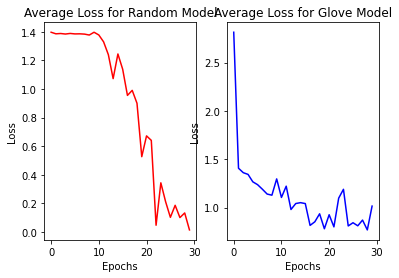

In [54]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot( random_avg_loss, 'r') 
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title("Average Loss for Random Model")


ax2.plot( glove_avg_loss, 'b') 
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title("Average Loss for Glove Model")
plt.show()



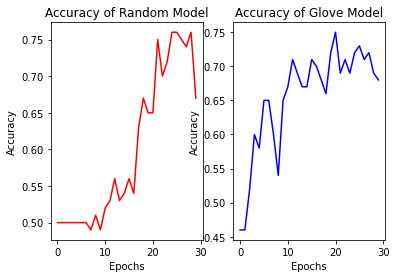

In [55]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot( random_accuracy, 'r') 
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.set_title("Accuracy of Random Model")


ax2.plot( glove_accuracy, 'b') 
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title("Accuracy of Glove Model")
plt.show()



## Free Response Questions (20 pts.):
1. Compare the performance of the Glove model vs the Random model. Refer to the validation accuracy curves and the test set results in your answer.
2. Compare the training loop between the supervised and unsupervised models. What's different (outside of code features like predicting validation accuracy after each epoch)?

1. 

    The Random Model has a very low accuracy for the first ~10 epochs, then dramaticly increases before leveling out. In contrast, the glove model

    From the loss graphs we can see that, in general, the Glove Model has a more stable performance and there are less dramatic fluctuations in the loss. Also, the glove model trains significantly faster than the Random model. This is likely due to the smaller number of hidden layers. 

------- 

2. 
    The Bigram and trigram models are language models that predicts the next word in a sequence based on the previous one word for bigram and two words for trigram. The Random and GloVe models are classification model that predicts whether a given sequence of words belongs to the positive or negative class.

    There are many differences between the training loops of the unsupervised (Bigram and Trigram) and supervised (Random and Glove Models): 
- The loss functions: The bigram and trigram models uses cross-entropy loss, while the Random and GloVe models use BCEWithLogitsLoss.

- Softmax: Bigram and Trigram use softmax and Random and GloVe models do not

- Prediction/Validation Check: During training the Glove and Random evaluate the model output each epoch using a predict function to check validation accuracy by comparing it to a labeled validation data set. Bigram and Trigram do not have a prediction validation check. Since there is no validation comparison we cannot tell if these models are overfitting. 

- Data input: The bigram and trigram model requires input sequence of two and three words, whereas the Random and GloVe model requires a dataset of word embeddings.

- The bigram and trigram model generate bigrams and trigrams from the raw text and do not use word embeddings, whereas the Random model randomly generates word embeddings from the raw text and the Glove model uses pretrained word embeddings.

- Model output: The bigram and trigram models output a probability distribution over the next word in the sequence, while the GloVe and Random models output a scalar representing the probability that the input belongs to the positive class.
